# Exercise 6b - Advanced segmentation. Fisherman's Linear discriminant analysis for segmentation

## Imports and functions

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
from skimage.morphology import opening, closing
from skimage.morphology import disk
from LDA import LDA
from matplotlib.colors import ListedColormap

## Lecture exercises

### Exercise 1 - Hough space
If we select $\theta$ to 60 degree what is r when the point is (x,y)=(201.5, 348.9)?
- Hough space: $r = x cos \theta + y sin \theta$

In [2]:
# Convert degrees to radians (math.radians(degrees))
# Convert radians to degrees (math.degrees(radians))
theta = 60
x, y = 201.5, 348.9

x*np.cos(math.radians(theta)) + y*np.sin(math.radians(theta))

402.90626338039067

## Image Segmentation

In [3]:
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

### Exercise 1 - 2D histogram and scatter-plot

![imshow image coordinates](figs/Picture1.png)

The two MRI image modalities contain different types of intensity classes:

1. (Orange): The White Matter (WM) is the tissue type that contain the brain network - like the cables in the internet. The  WM ensure the communication flow between functional brain regions.
2. (Yellow): The Grey Matter (GM) is the tissue type that contain the cell bodies at the end of the brain network and are the functional units in the brain. The functional units are like CPUs in the computer. They are processing our sensorial input and are determining a reacting to these. It could be to start running.
3. (Magenta): Cerebrospinal fluid (CSF) which is the water in the brain 
4. (Green): Background of the image

Display both the T1 and T2 images, their 1 and 2D histograms and scatter plots. 



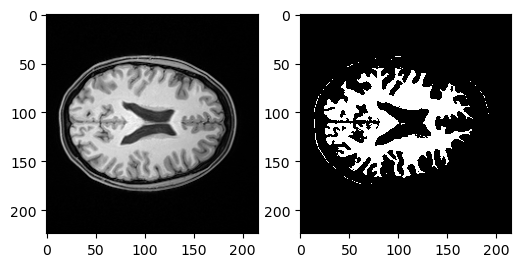

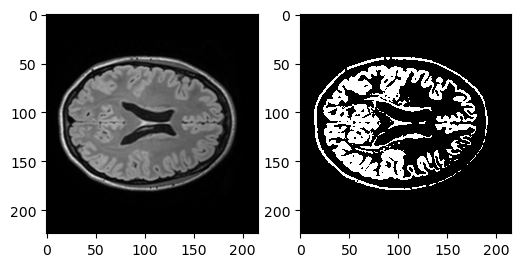

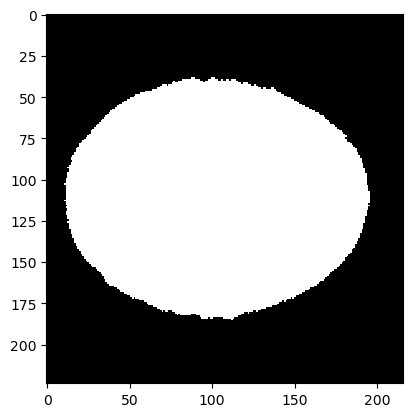

In [153]:
# T1
thres_T1 = ImgT1 > 500

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
axs[0].imshow(ImgT1, cmap = 'gray')
axs[1].imshow(thres_T1, cmap = 'gray', interpolation = 'none')
plt.show()

# T2
thres_T2 = ImgT2 > 165

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
axs[0].imshow(ImgT2, cmap = 'gray')
axs[1].imshow(thres_T2, cmap = 'gray', interpolation = 'none')
plt.show()

# Remove background 
mask_init = ImgT1 > 10
mask = opening(mask_init, disk(2))
mask_no_backgroud = closing(mask, disk(3))

plt.imshow(mask_no_backgroud, cmap = 'gray', interpolation = 'none')

plt.show()

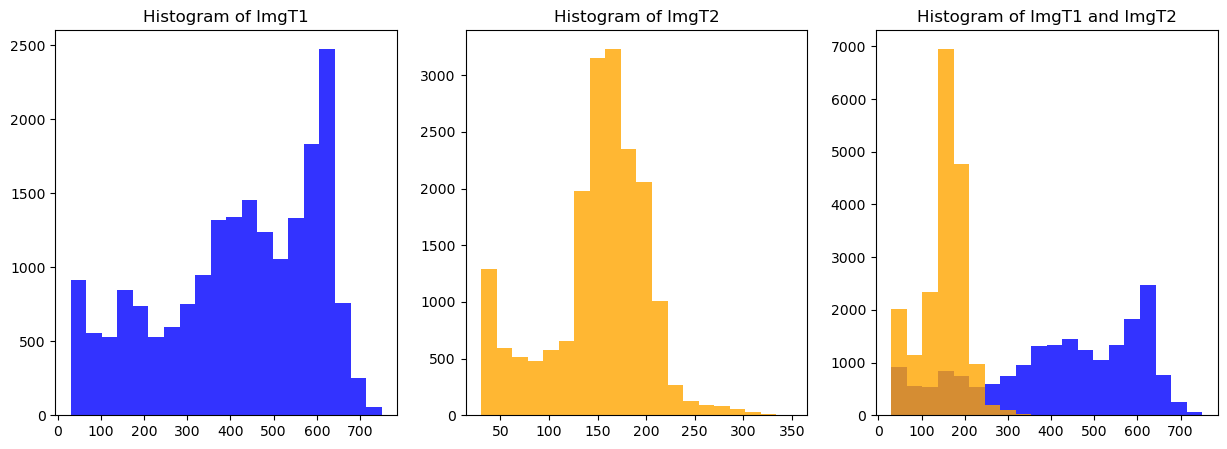

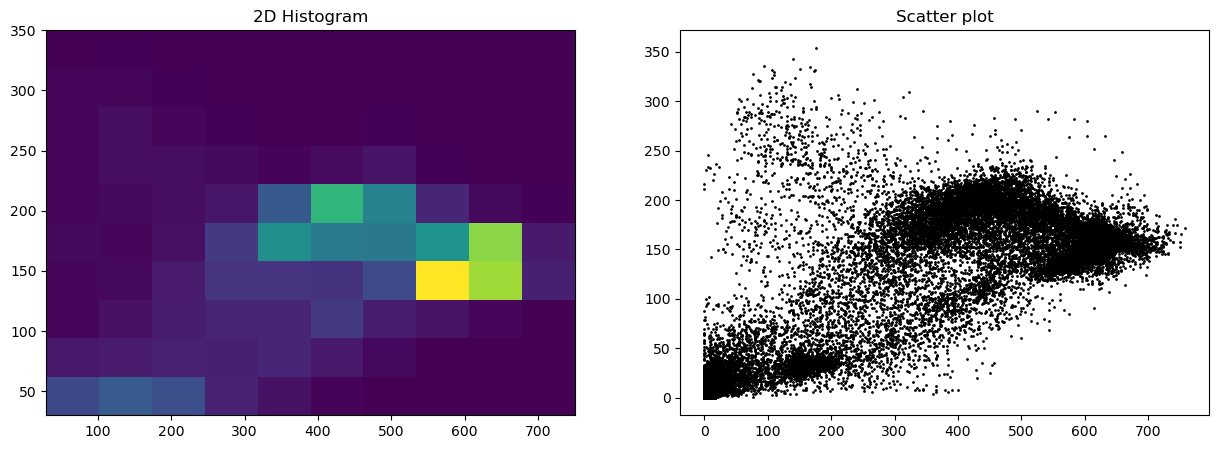

In [33]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots: two for the 1D histograms and one for the 2D histogram
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the 1D histograms
axs[0].hist(ImgT1.flatten(), bins=20, color='blue', alpha=0.8, range=(30, 750))
axs[1].hist(ImgT2.flatten(), bins=20, color='orange', alpha=0.8, range=(30, 350))
axs[2].hist(ImgT1.flatten(), bins=20, color='blue', alpha=0.8, range=(30, 750))
axs[2].hist(ImgT2.flatten(), bins=20, color='orange', alpha=0.8, range=(30, 750))
            
# Add titles
axs[0].set_title('Histogram of ImgT1')
axs[1].set_title('Histogram of ImgT2')
axs[2].set_title('Histogram of ImgT1 and ImgT2')

### 2D histogram and a scatter plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the 2D histogram
axs[0].hist2d(ImgT1.flatten(), ImgT2.flatten(), range=[[30, 750], [30, 350]])
axs[1].scatter(ImgT1.flatten(), ImgT2.flatten(), s=1, color='black')

axs[0].set_title('2D Histogram')
axs[1].set_title('Scatter plot')

# Show the plot
plt.show()


**Q1**: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histograms? 

500 for T1 and 165 for T2 seems like a good fit



### Exercise 2 - Show training
Place trainings examples i.e. ROI_WM and ROI_GM into variables C1 and C2 representing class 1 and class 2 respectively. Show in a figure the manually expert drawings of the C1 and C2 training examples.

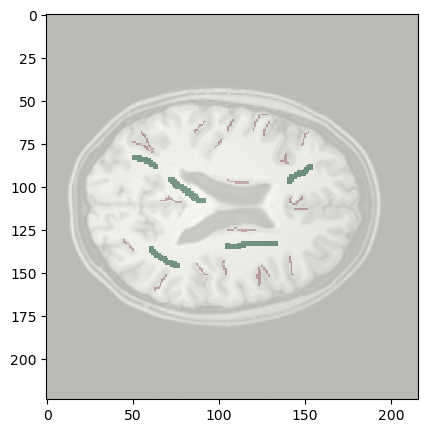

In [28]:
C1 = ROI_GM
C2 = ROI_WM

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axs.imshow(ImgT1, cmap = 'gray')
axs.imshow(C1, cmap = 'Reds', alpha = 0.5, interpolation = 'none')
axs.imshow(C2, cmap = 'Greens', alpha = 0.5, interpolation = 'none')
plt.show()

### Exercise 3 - Seperate based on training
For each binary training ROI find the corresponding training examples in ImgT1 and ImgT2. Later these will be extracted for LDA training.

**Q4:** What is the difference between the 1D histogram of the training examples and the 1D histogram of the whole image? Is the difference expected?

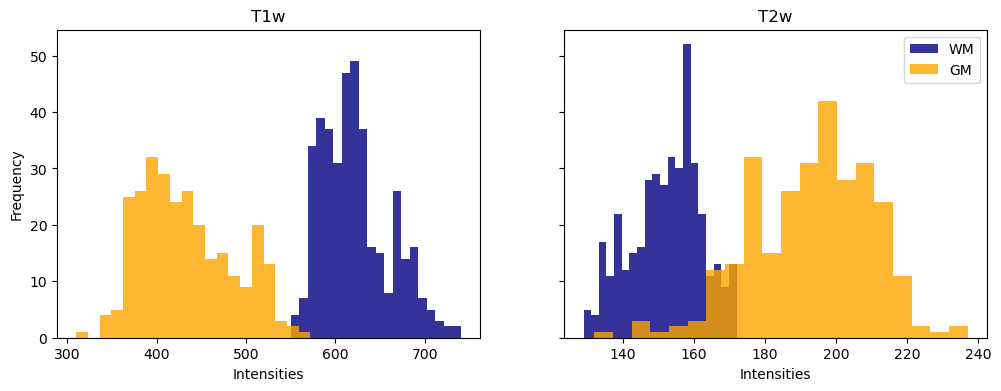

In [35]:
trainWM_T1 = ImgT1[ROI_WM]
trainGM_T1 = ImgT1[ROI_GM]

trainWM_T2 = ImgT2[ROI_WM] 
trainGM_T2 = ImgT2[ROI_GM] 

fig, axs = plt.subplots(1, 2, figsize = (12, 4), sharex = False, sharey = True)
axs[0].hist(trainWM_T1, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[0].hist(trainGM_T1, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Intensities')
axs[0].set_title('T1w')

axs[1].hist(trainWM_T2, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[1].hist(trainGM_T2, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[1].set_xlabel('Intensities')
axs[1].set_title('T2w')
plt.legend()
plt.show()


### Exercise 4
Make a training data vector (X) and target class vector (T) as input for the LDA() function. T and X should have the same length of data points.

X: Training data vector should first include all data points for class 1 and then the data points for class 2. Data points are the two input features ImgT1, ImgT2

T: Target class identifier for X where '0' are Class 1 and a '1' is Class 2.

In [111]:
# Feature matrix, X -> Shape: (n_samples, n_features)
X1 = np.c_[ImgT1[ROI_WM], ImgT2[ROI_WM]] # Shape: (399,2)
X2 = np.c_[ImgT1[ROI_GM], ImgT2[ROI_GM]] # Shape: (280,2)
X = np.r_[X1, X2] # WM, GM Shape: (679,2)

# Label vector, T -> Shape: (n_samples)
n_pixels = X.shape[0]
n_wm_pixels = X1.shape[0]
T = np.zeros((n_pixels, 1))
T[n_wm_pixels:] = 1

### Exercise 5
Make a scatter plot of the training points of the two input features for class 1 and class 2 as green and black circles, respectively. Add relevant title and labels to axis

**Q5:** How does the class separation appear in the 2D scatter plot compared with 1D histogram. Is it better?

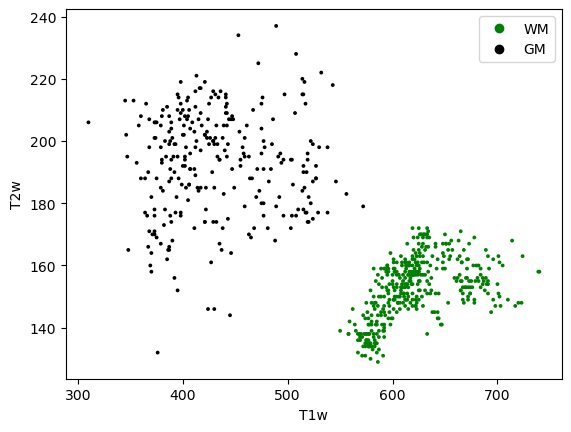

In [112]:
cmap = ListedColormap(['green', 'black'])
scatter = plt.scatter(X.T[0], X.T[1], c = T, cmap = cmap, s = 3)
plt.legend(handles = scatter.legend_elements()[0], labels = ('WM', 'GM'))
plt.xlabel('T1w')
plt.ylabel('T2w')
plt.show()


### Exercise 6
Train the linear discriminant classifier using the Fisher discriminant function and estimate the weight-vector coefficient W (i.e. w0 and w) for classification given X and T by using the W=LDA() function. The LDA function outputs W=[[w01, w1]; [w02, w2]] for class 1 and 2 respectively.


In [113]:
W = LDA(X,T)
W

array([[-138.11536977,    0.27566672,    0.68044071],
       [-131.32787698,    0.15900268,    0.99568003]])

### Exercise 7 -  multi-modal classification
Apply the linear discriminant classifier i.e. perform multi-modal classification using the trained weight-vector W for each class: It calculates the linear score Y for all image data points within the brain slice i.e. y(x)=w+w0. Actually, y(x) is the log(P(Ci∣x)).

In [114]:
Xall = np.c_[ImgT1.ravel(), ImgT2.ravel()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

### Exercise 8
Perform multi-modal classification: Calculate the posterior probability i.e. P(C1∣X) of a data point belonging to class 1

In [116]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1)

### Exercise 9
Apply segmentation: Find all voxles in the T1w and T2w image with P(C1∣X)>0.5 as belonging to Class 1. You may use the np.where() function. Similarly, find all voxels belonging to class 2.

In [159]:
PP_WM = PosteriorProb[:,0] >= 0.5
PP_GM = PosteriorProb[:,1] > 0.5
Img_PP_WM = PP_WM.reshape(ImgT1.shape)
Img_PP_GM = PP_GM.reshape(ImgT1.shape)

''' If i want no background

posteriorC1 = np.zeros(ImgT1.shape)
posteriorC2 = np.zeros(ImgT1.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 >= 0.5
mask_GM = posteriorC2 > 0.5
'''

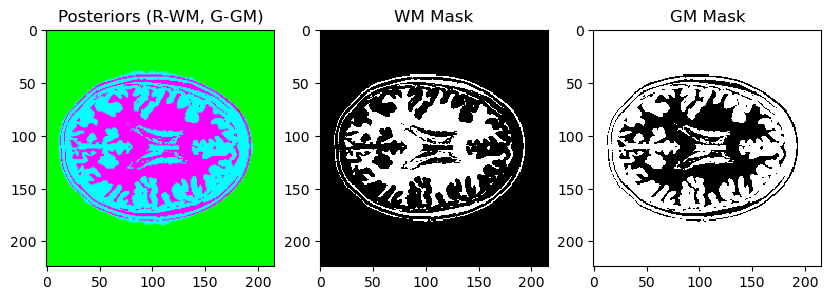

In [160]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
rgb = np.stack((Img_PP_WM, Img_PP_GM, mask_no_backgroud), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(Img_PP_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(Img_PP_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

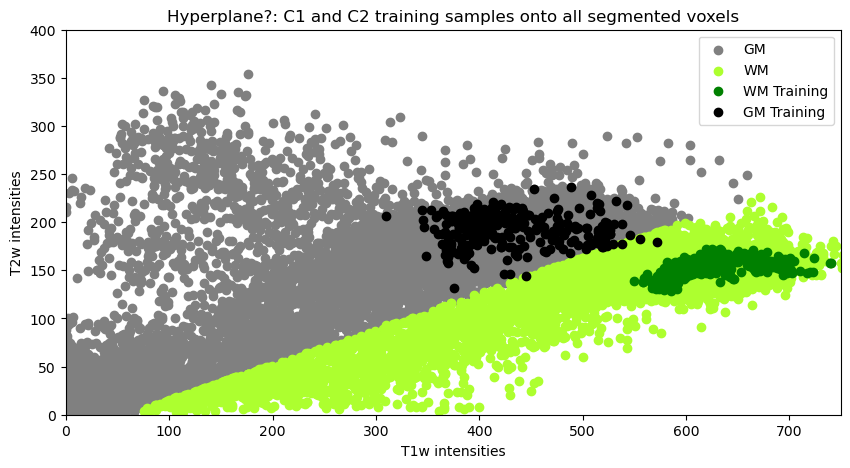

In [164]:
Xall_WM = Xall[PosteriorProb[:,0] > 0.5, :]
Xall_GM = Xall[PosteriorProb[:,1] > 0.5, :]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(Xall_GM[:,0], Xall_GM[:,1], c = 'gray', label = 'GM')
ax.scatter(Xall_WM[:,0], Xall_WM[:,1], c = 'greenyellow', label = 'WM')
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'WM Training')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'GM Training')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
ax.set_title('Hyperplane?: C1 and C2 training samples onto all segmented voxels')

plt.axis([0, 750, 0, 400])
plt.legend()
plt.show()

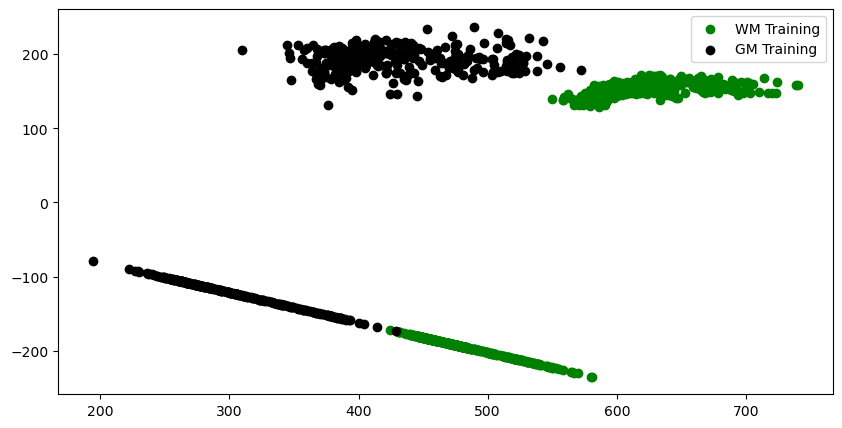

In [163]:
# Projection of the training data onto the hyperplane

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'WM Training')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'GM Training')
W_ = W[0,1:] # The weights indicate the normal to the hyperplane, for the projection we need the perpendicular
W_ = (W_/np.linalg.norm(W_))[::-1]
W_[0] = -W_[0]
for point in X1:
  proj = np.dot(point,W_)/np.dot(W_,W_) * W_
  ax.scatter(proj[0],proj[1],color='g')

for point in X2:
  proj = np.dot(point,W_)/np.dot(W_,W_) * W_
  ax.scatter(proj[0],proj[1],color='k')

plt.legend()
plt.show()

# JUNK!!

In [165]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

model = LinearDiscriminantAnalysis()
model.fit(X, T)



c:\Users\Naja-\anaconda3\envs\image\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

In [ ]:
X1 = np.array([[4, 2], [2, 4], [2, 3], [3, 6], [4, 4]])
X2 = np.array([[9, 10], [6, 8], [9, 5], [8, 7], [10, 8]])
X = np.r_[X1, X2]

n_pixels = X.shape[0]
n_wm_pixels = X1.shape[0]
T = np.zeros((n_pixels, 1))
T[n_wm_pixels:] = 1
from LDA import LDA
W = LDA(X, T)

print('W:', W)

mu1 = np.mean(np.array(X1), axis=0)
mu2 = np.mean(X2, axis=0)
mu_diff = np.abs(mu1 - mu2)
print('Mean Vector 1:', mu1, '\nMean Vector 2:', mu2, '\nDifference:', mu_diff)


s1 = np.cov(X1.T)
s2 = np.cov(X2.T)
Sw = s1 + s2 
print('\nWithin-class scatter matrix:\n', Sw)

Sb = np.outer(mu_diff, mu_diff) 
print('\nBetween class scatter matrix:\n', Sb)

vec = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
print('\nThe eigenvalues found: ', vec.eigenvalues)
print('The eigenvectors found:\n', vec.eigenvectors)
print('Use the LDA projection vector with highest eigenvalue:', max(vec.eigenvalues), 'and corresponding eigenvector:', vec.eigenvectors[:,0])

for i in range(len(vec.eigenvalues)):
    eigvec_sc = vec.eigenvectors[:,i].reshape(2,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, vec.eigenvalues[i].real))

W: [[ -6.45128672   1.95348837   1.48837209]
 [-34.85660233   5.36877076   3.05647841]]
Mean Vector 1: [3.  3.8] 
Mean Vector 2: [8.4 7.6] 
Difference: [5.4 3.8]

Within-class scatter matrix:
 [[ 3.3 -0.3]
 [-0.3  5.5]]

Between class scatter matrix:
 [[29.16 20.52]
 [20.52 14.44]]

The eigenvalues found:  [1.22006645e+01 8.04682872e-16]
The eigenvectors found:
 [[ 0.90878558 -0.57549341]
 [ 0.41726342  0.81780642]]
Use the LDA projection vector with highest eigenvalue: 12.200664451827244 and corresponding eigenvector: [0.90878558 0.41726342]

Eigenvector 1: 
[[0.90878558]
 [0.41726342]]
Eigenvalue 1: 1.22e+01

Eigenvector 2: 
[[-0.57549341]
 [ 0.81780642]]
Eigenvalue 2: 8.05e-16


In [ ]:
cov = np.array([[2, 0], [0, 2]])
c1_mu = np.array([24, 3]).T
c2_mu = np.array([30, 7]).T
x = np.array([23, 5]).T
mu_diff =  np.abs(c1_mu - c2_mu)
print('mu_diff: ', mu_diff)

Sw = cov
print('\nWithin-class scatter matrix:\n', Sw)

Sb = np.outer(mu_diff, mu_diff) 
print('\nBetween class scatter matrix:\n', Sb)

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
print('\nThe eigenvalues found: ', eig_vals)
print('The eigenvectors found:\n', eig_vecs)
w = eig_vecs[:,np.argmax(eig_vals)]
e = max(eig_vals)
print('Use the LDA projection vector with highest eigenvalue:', e, 'and corresponding eigenvector:', w)

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(2,1) # put in class  
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))
    
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

W = np.hstack((eig_pairs[0][1].reshape(2,1), eig_pairs[1][1].reshape(2,1)))
print('Matrix W:\n', W.real)

X_lda = x.dot(W)
X_lda
x.dot(W)

mu_diff:  [6 4]

Within-class scatter matrix:
 [[2 0]
 [0 2]]

Between class scatter matrix:
 [[36 24]
 [24 16]]

The eigenvalues found:  [2.6000000e+01 4.4408921e-16]
The eigenvectors found:
 [[ 0.83205029 -0.5547002 ]
 [ 0.5547002   0.83205029]]
Use the LDA projection vector with highest eigenvalue: 26.0 and corresponding eigenvector: [0.83205029 0.5547002 ]

Eigenvector 1: 
[[0.83205029]
 [0.5547002 ]]
Eigenvalue 1: 2.60e+01

Eigenvector 2: 
[[-0.5547002 ]
 [ 0.83205029]]
Eigenvalue 2: 4.44e-16
Matrix W:
 [[ 0.83205029 -0.5547002 ]
 [ 0.5547002   0.83205029]]


array([21.91065775, -8.59785304])

In [ ]:
from LDA import LDA

pooled_cov = 2 * np.eye(2)
group_mean = np.array([[30, 7], [24, 3]])
x = np.array([[23], [5]])
group_diff = group_mean[1, :] - group_mean[0, :]
group_diff = group_diff[:, None]

w = np.linalg.inv(pooled_cov) @ group_diff
c = -0.5 * np.sum(group_mean, axis=0, keepdims=True)
w0 = c @ w
y = x.T @ w + w0
print('y: ', y)

prior_prob = [[0.5], [0.5]]
m = 2  # n dimensions
k = 2  # n classes
W = np.zeros((k, m + 1))

for i in range(k):
    # Intermediate calculation for efficiency
    temp = group_mean[i, :][np.newaxis] @ np.linalg.inv(pooled_cov)
    # Constant
    W[i, 0] = -0.5 * temp @ group_mean[i, :].T + np.log(prior_prob[i])
    # Linear
    W[i, 1:] = temp

Y = np.array([[1, 23, 5]]) @ W.T
posteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y), 1)[:, np.newaxis], 0, 1)

print('Y: ' , Y)
print('posteriorProb: ', posteriorProb)


w:  [[-3.]
 [-2.]]
y:  [[12.]]
Y:  [[124.55685282 136.55685282]]
posteriorProb:  [[6.14417460e-06 9.99993856e-01]]


C:\Users\Naja-\AppData\Local\Temp\ipykernel_13076\182852294.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i, 0] = -0.5 * temp @ group_mean[i, :].T + np.log(prior_prob[i])
